<a href="https://colab.research.google.com/github/jing-yu-lim/Understanding-DETR-Transformer-Self-Attention-Maps-Visualisation/blob/main/Understanding_Transformer_Self_Attention_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
import torchvision
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

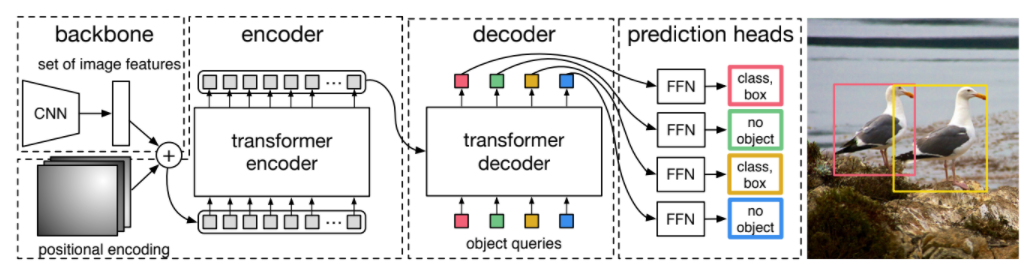

In [ ]:
transforms=T.Compose([
                      T.Resize(800),
                      T.ToTensor(),
                      T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

model=torch.hub.load('facebookresearch/detr','detr_resnet50',pretrained=True)
model.eval()

In [ ]:
#select image of choice from URL
url='https://thesmartlocal.com/wp-content/uploads/2015/01/images_easyblog_images_2088_Hock_Lam.jpg'
im=Image.open(requests.get(url,stream=True).raw)
img=transforms(im).unsqueeze(0)
print(f'The shape of the img:{img.shape}')

In [ ]:
#using hooks to extract attention weights
#extract conv features to derive the shape of the backbone output

conv_features,enc_attn_weights=[],[]

hooks=[
        model.backbone[0].register_forward_hook(
            lambda self, input, output: conv_features.append(output)),

        model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output))
]

outputs=model(img)

for hook in hooks:
  hook.remove()

conv_features=conv_features[0]
enc_attn_weights=enc_attn_weights[0]

In [ ]:
conv_shape=conv_features['0'].tensors.shape
print(f'shape of conv backbone output: {conv_shape}')
shape=conv_shape[-2:]
sattn_shape1=enc_attn_weights[1][0].reshape(shape+shape)
sattn_shape2=enc_attn_weights[1][0]
print('reshaped self-attention shape 1:',sattn_shape1.shape)
print('reshaped self-attention shape 2:',sattn_shape2.shape)


The converted pixel_num is 928


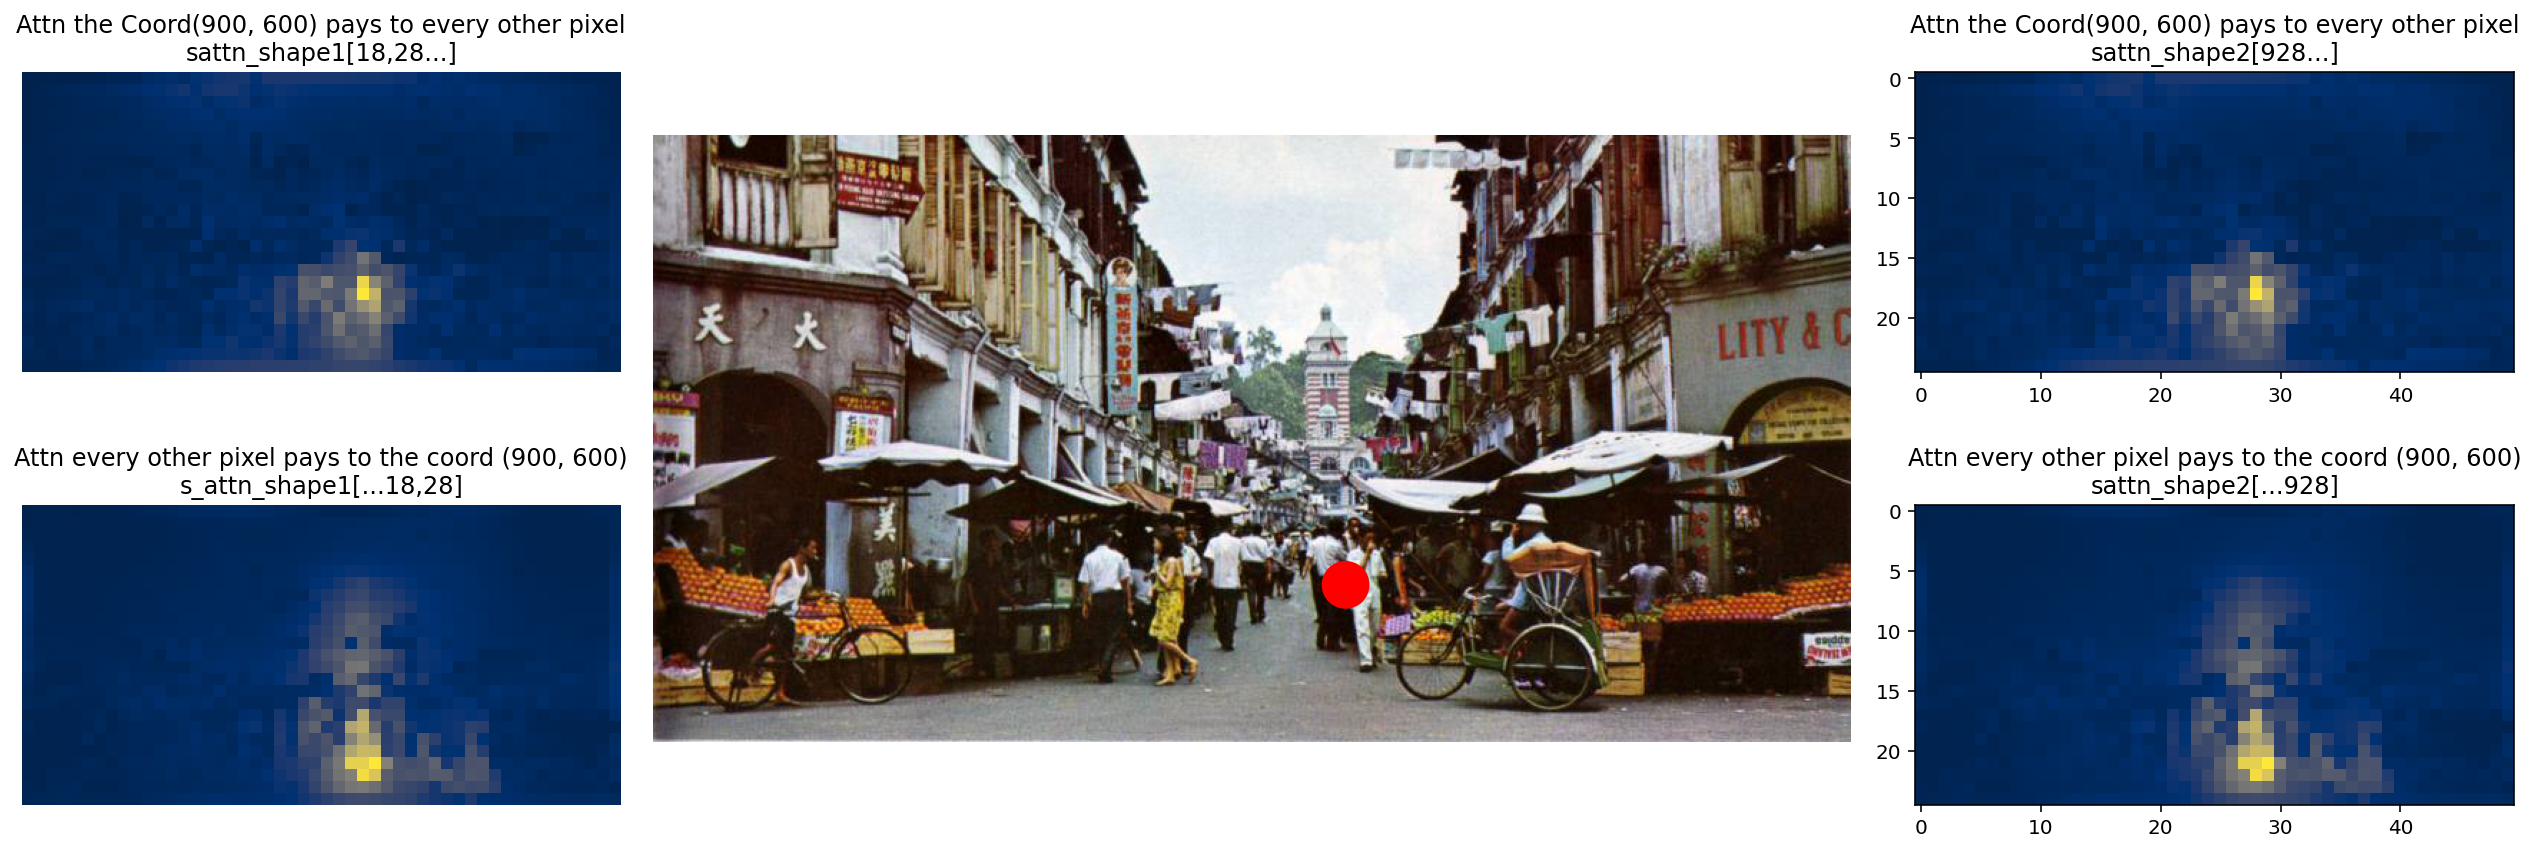

In [9]:
#select a Coordinate (X,Y) of choice
idxs= (900,600)

x=idxs[0]
y=idxs[1]

# downsampling factor for the CNN backbone, from input image to output feature map 
fact = 32

#create the canvas
fig=plt.figure(constrained_layout=True,figsize=(25*0.7,8.5*0.7))
#add one plot per reference point
gs=fig.add_gridspec(2,4)
axs=[
     fig.add_subplot(gs[0,0]),
     fig.add_subplot(gs[1,0]),
     fig.add_subplot(gs[0,-1]),
     fig.add_subplot(gs[1,-1]),
]

#Plotting the self attn map using sattn_shape1
idx=(x // fact, y // fact) 
axs[0].imshow(sattn_shape1[idx[1],idx[0],...],cmap='cividis',interpolation='nearest')
axs[0].axis('off')
axs[0].set_title(f'Attn the Coord{idxs} pays to every other pixel\nsattn_shape1[{idx[1]},{idx[0]}...]')
axs[1].imshow(sattn_shape1[...,idx[1],idx[0]],cmap='cividis',interpolation='nearest')
axs[1].axis('off')
axs[1].set_title(f'Attn every other pixel pays to the coord {idxs}\ns_attn_shape1[...{idx[1]},{idx[0]}]')

# and now let's add the central image, with the reference points as red circles
fcenter_ax=fig.add_subplot(gs[:,1:-1])# choose which gridspecs to use!
fcenter_ax.imshow(im)
scale = im.height / img.shape[-2]
x=((x // fact) + 0.5) * fact
y=((y // fact) + 0.5) *fact
fcenter_ax.add_patch(plt.Circle((x*scale,y*scale),fact//2,color='r'))
fcenter_ax.axis('off')

#obtain the pixel_num by flattening the inputs to the sattn_shape1 slice
pixel_num=idx[1]*conv_shape[-1]+idx[0]
print(f'The converted pixel_num is {pixel_num}')

#Plotting the self attn map using sattn_shape2
map_1=sattn_shape2[pixel_num,...].reshape(shape)
axs[2].imshow(map_1,cmap='cividis',interpolation='nearest')
axs[2].set_title(f'Attn the Coord{idxs} pays to every other pixel\nsattn_shape2[{pixel_num}...]')
map_2=sattn_shape2[...,pixel_num].reshape(shape)
axs[3].imshow(map_2,cmap='cividis',interpolation='nearest')
axs[3].set_title(f'Attn every other pixel pays to the coord {idxs}\nsattn_shape2[...{pixel_num}]')

plt.savefig('shape1 vs shape2')